In [1]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

print(sys.path[-1])  
import os
print(os.getcwd())

/Users/seobi/PythonProjects/RAG_Commander/src
/Users/seobi/PythonProjects/RAG_Commander/src/agents/main


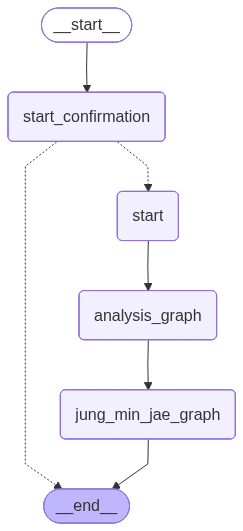

In [2]:
from agents.main.main_agent import graph_builder
graph = graph_builder.compile()
graph

In [3]:
from utils.format_message import format_message
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from agents.state.main_state import MainState
messages_key = MainState.KEY.messages
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer = checkpointer)

thread = {"configurable": {"thread_id":"1"}}
result = await graph.ainvoke(
    {
        messages_key : [HumanMessage(content = "서울 강남구 역삼동 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ")]
    },
    config = thread
)

format_message(result[messages_key])

2025-11-02 16:09:09,657 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:10,928 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:11,537 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:11,617 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/Users/seobi/PythonProjects/RAG_Commander/src/tools/rag/retriever/age_population_retriever.py:32: LangChainPendingDeprecationWarning: This class is pending deprecation and may be removed in a future version. You can swap to using the `PGVector` implementation in `langchain_postgres`. Please read the guidelines in the doc-string of this class to follow prior to migrating as there are some differences between the implementations. See <https://github.com/langchain-ai/langchain-postgres> for details about the new implementation.
  store = PGVecto

서울 강남구
10년이상 노후도 호출 질문 강남구
10년이상 노후도 호출 결과 {'result': [{'house_cnt': '4166', 'adm_cd': '11230', 'adm_nm': '강남구'}], 'errCd': 0, 'errMsg': 'Success', 'id': 'API_0306', 'trId': 'Mq=Z_API_0306_1762067351879'}


2025-11-02 16:09:12,532 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:12,671 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-02 16:09:12,743 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


연령층 분포 
행정구역: 강남구
2025년04월_계_총인구수: 556,822
2025년04월_계_연령구간인구수: 556,822
2025년04월_계_0~9세: 32,770
2025년04월_계_10~19세: 63,574
2025년04월_계_20~29세: 65,177
2025년04월_계_30~39세: 81,030
2025년04월_계_40~49세: 100,502
2025년04월_계_50~59세: 88,228
2025년04월_계_60~69세: 63,700
2025년04월_계_70~79세: 42,567
2025년04월_계_80~89세: 16,590
2025년04월_계_90~99세: 2,598
2025년04월_계_100세 이상: 86
2025년04월_남_총인구수: 266,037
2025년04월_남_연령구간인구수: 266,037
2025년04월_남_0~9세: 16,789
2025년04월_남_10~19세: 33,170
2025년04월_남_20~29세: 30,601
2025년04월_남_30~39세: 38,070
2025년04월_남_40~49세: 45,927
2025년04월_남_50~59세: 44,134
2025년04월_남_60~69세: 29,723
2025년04월_남_70~79세: 19,246
2025년04월_남_80~89세: 7,622
2025년04월_남_90~99세: 737
2025년04월_남_100세 이상: 18
2025년04월_여_총인구수: 290,785
2025년04월_여_연령구간인구수: 290,785
2025년04월_여_0~9세: 15,981
2025년04월_여_10~19세: 30,404
2025년04월_여_20~29세: 34,576
2025년04월_여_30~39세: 42,960
2025년04월_여_40~49세: 54,575
2025년04월_여_50~59세: 44,094
2025년04월_여_60~69세: 33,977
2025년04월_여_70~79세: 23,321
2025년04월_여_80~89세: 8,968
2025년04월_여_90~99세: 1,861
2025년04월_

2025-11-02 16:09:15,222 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[{'title': '서울 상봉역·용마산역·창2동, ‘도심 공공주택 복합지구’ 지정…2,148가구 공급', 'date': '2025.10.31 09:21', 'content': "서울 중랑구 상봉역 인근 '도심 공공주택 복합지구' 조감도. 상봉역 인근은 역세권 고밀 복합 개발을 통해 주거와 생활 인프라를 함께 공급하는 방향으로 추진된다. (자료=국토교통부)\n[하우징포스트=박영신 대기자]\n국토교통부는 31일 서울 중랑구 상봉역·용마산역 인근과 도봉구 창2동 주민센터 일대 등 3곳 총 2,148가구가 ‘도심 공공주택 복합지구’로 지정됐다고 밝혔다.\n해당 구역들은 예정지구 지정 후 주민 3분의 2 이상 동의 요건을 충족하고, 중앙도시계획위원회 및 중앙토지수용위원회 심의를 거쳐 지정 절차를 완료했다.\n'도심 공공주택 복합사업'은 노후 도심에서 주택 공급을 빠르게 확대하기 위한 '공공 주도형 정비 사업(재개발·재건축)'이다. 민간 정비가 지연되는 지역에 용적률·건축규제 완화 등 인센티브를 제공하고, 심의 절차를 통합하여 사업 속도를 높이는 방식이 적용된다.\n이번 지구 지정으로 상봉역·용마산역 일대는 역세권 고밀 복합 개발, 창2동 주민센터 인근은 준공업지역을 활용한 주거·생활 인프라 복합 공급이 추진된다. 사업은 통합심의를 거쳐 2027년 복합사업계획 승인, 2030년 착공을 목표로 한다.\n이로써 전체 도심복합사업 후보지 49곳 중 26곳, 약 4만 1,000가구 규모의 지구 지정이 완료됐다. 이번 조치는 지난 9월 발표된 ‘주택공급 확대방안(9·7 대책)’의 후속 단계이기도 하다. 정부는 도심 주택 공급 속도를 높이기 위해 법령 개정과 제도 개선을 연내 병행할 계획이다.\n국토부는 '공공주택 특별법' 개정을 통해 건축물 높이 제한 완화 등 특례를 확대하고, 통합심의 대상에 환경영향평가·소방성능설계를 포함할 예정이다. 또한 준주거지역에만 적용되던 용적률 법적상한 1.4배 완화 규정을 주거지역 전체로 확대하는 시행령 개정도 추진된다.\n김배성 국토교통부 공공주

2025-11-02 16:09:19,744 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:24,669 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:35,126 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:39,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:43,898 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:09:51,840 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:11:49,957 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:12:31,389 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-02 16:13:25,275 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

TypeError: No synchronous function provided to "pre_pomise_competition".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

In [ ]:
result

In [ ]:
print(result['final_report'])